In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random, nn, vmap
from functools import partial
import optax

from models import exact_blr, log_ratio, BayesRegression, SVIRegression, BMRRegression, LinearizedRegression

In [4]:
def plot_posteriors(posterior_smpls, labels=['Linear regression', 'Logistic regression', 'Multinomial regression']):
    fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharex=True, sharey='row')

    sns.boxenplot(posterior_smpls['nobmr']['norm'], color='b', ax=axes[0, 0], showfliers=False, outlier_prop=1e-3);
    axes[0, 0].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, 0].set_title('No-BMR')

    sns.boxenplot(posterior_smpls['bmr']['norm'], color='b', ax=axes[0, 1], showfliers=False, outlier_prop=1e-3);
    axes[0, 1].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, 1].set_title('BMR')

    sns.boxenplot(posterior_smpls['svi']['norm'], color='b', ax=axes[0, 2], showfliers=False, outlier_prop=1e-3);
    axes[0, 2].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, 2].set_title('SVI')

    sns.boxenplot(posterior_smpls['mcmc']['norm'], color='b', ax=axes[0, -1], showfliers=False, outlier_prop=1e-3);
    axes[0, -1].plot(nn.one_hot(0, num_classes=D), 'rd');
    axes[0, -1].set_title('NUTS')

    axes[0, -1].yaxis.set_label_position("right")
    axes[0, -1].set_ylabel(labels[0], rotation=-90, fontsize=12)

    sns.boxenplot(posterior_smpls['nobmr']['bern'], color='b', ax=axes[1, 0], showfliers=False, outlier_prop=1e-3);
    axes[1, 0].plot(nn.one_hot(0, num_classes=D), 'rd');

    sns.boxenplot(posterior_smpls['bmr']['bern'], color='b', ax=axes[1, 1], showfliers=False, outlier_prop=1e-3);
    axes[1, 1].plot(nn.one_hot(0, num_classes=D), 'rd');

    sns.boxenplot(posterior_smpls['svi']['bern'], color='b', ax=axes[1, 2], showfliers=False, outlier_prop=1e-3);
    axes[1, 2].plot(nn.one_hot(0, num_classes=D), 'rd');

    sns.boxenplot(posterior_smpls['mcmc']['bern'], color='b', ax=axes[1, -1], showfliers=False, outlier_prop=1e-3);
    axes[1, -1].plot(nn.one_hot(0, num_classes=D), 'rd');

    axes[1, -1].yaxis.set_label_position("right")
    axes[1, -1].set_ylabel(labels[1], rotation=-90, fontsize=12)

    sns.boxenplot(posterior_smpls['nobmr']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, 0], showfliers=False, outlier_prop=1e-3);
    axes[-1, 0].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    sns.boxenplot(posterior_smpls['bmr']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, 1], showfliers=False, outlier_prop=1e-3);
    axes[-1, 1].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    sns.boxenplot(posterior_smpls['svi']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, 2], showfliers=False, outlier_prop=1e-3);
    axes[-1, 2].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    sns.boxenplot(posterior_smpls['mcmc']['cat'].reshape(-1, _D * 10), color='b', ax=axes[-1, -1], showfliers=False, outlier_prop=1e-3);
    axes[-1, -1].plot(nn.one_hot(jnp.arange(10), num_classes=D)[:, :10].reshape(-1), 'rd');

    axes[-1, -1].yaxis.set_label_position("right")
    axes[-1, -1].set_ylabel(labels[2], rotation=-90, fontsize=12)

    axes[-1, 0].set_xticks(ticks=[]);
    axes[-1, -1].set_xticks(ticks=[]);
    for i in range(4):
        if i < 3:
            axes[i, 0].set_ylabel('coefficient value')
        axes[-1, i].set_xlabel('coefficient index')

    fig.tight_layout()
    sns.despine(fig, bottom=True)

    return fig

In [5]:
seed = 2982666625879488464
rng_key = random.PRNGKey(seed)

D = 100
N = 100

rng_key, _rng_key = random.split(rng_key)
X_norm = random.normal(_rng_key, shape=(N, D))

rng_key, _rng_key = random.split(rng_key)
y_norm = X_norm @ nn.one_hot(0, num_classes=D) + random.normal(_rng_key, shape=(N,))

N = 2 * N
X_bern = random.normal(_rng_key, shape=(N, D))
rng_key, _rng_key = random.split(rng_key)
y_bern = random.bernoulli(_rng_key, nn.sigmoid(X_bern @ nn.one_hot(0, num_classes=D)))

_D = 10
N = 2 * N
X_cat = random.normal(_rng_key, shape=(N, _D))
rng_key, _rng_key = random.split(rng_key)
y_cat = random.categorical(_rng_key, X_cat @ nn.one_hot(jnp.arange(10), num_classes=_D).T)

## Exact Bayesian inference for normal likelihood

In [6]:
mu_n, P_n, a_n, b_n = exact_blr(X_norm, y_norm)

L_n = jnp.linalg.cholesky(jnp.linalg.inv(P_n))

params = {
    'a': a_n,
    'b': b_n,
    'mu': mu_n,
    'L': L_n,
}

rng_key, _rng_key = random.split(rng_key)
sigma_square = dist.InverseGamma(a_n, b_n).sample(_rng_key, sample_shape=(1000,))

rng_key, _rng_key = random.split(rng_key)
eps = random.normal(_rng_key, shape=(1000, D)) * jnp.expand_dims(jnp.sqrt(sigma_square), -1)
betas = mu_n + (L_n @ eps.T).T

samples = {
    'beta': betas,
    'sigma': jnp.sqrt(sigma_square)
}

lr = partial(log_ratio, X_norm, y_norm, params)
print('F', vmap(lr)(samples).mean())

F 221.19566


0.117527686 0.016620925


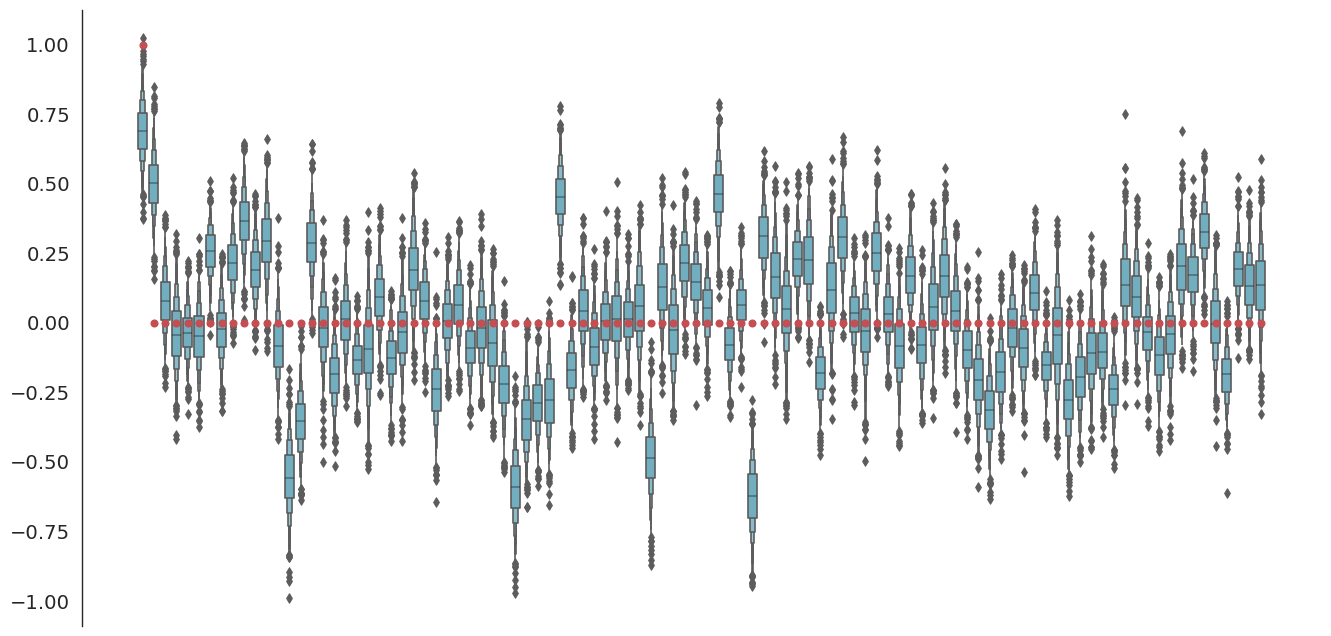

In [7]:
print( b_n/(a_n - 1), b_n/ jnp.sqrt((a_n-1)**2 * (a_n - 2)) )

plt.figure(figsize=(16, 8))
sns.boxenplot(betas, color='c');
plt.plot(nn.one_hot(0, num_classes=D), 'ro');
plt.xticks(ticks=[]);
sns.despine(bottom=True)

## No-U-turn sampler

In [8]:
posterior = {
    'nobmr': {},
    'bmr': {},
    'svi': {},
    'mcmc': {}
}

In [9]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

bayes_reg = BayesRegression(_rng_key, X_norm, linnet)
smpl_norm = bayes_reg.fit(y_norm, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=False)
posterior['mcmc']['norm'] = smpl_norm['beta']

rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_bern, linnet, regtype='logistic')

smpl_bern = bayes_reg.fit(y_bern, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=False)
posterior['mcmc']['bern'] = smpl_bern['beta']

rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(_D, 10, use_bias=False, key=_rng_key)])

rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_cat, linnet, regtype='multinomial')

smpl_cat = bayes_reg.fit(y_cat, num_samples=250, warmup_steps=500, num_chains=4, progress_bar=False)
posterior['mcmc']['cat'] = smpl_cat['beta']


## Stochastic variational inference

In [10]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

svi_reg = SVIRegression(_rng_key, X_norm, linnet, regtype='linear')
svi_smpl_norm = svi_reg.fit(y_norm, num_steps=50_000, autoguide='multivariate', progress_bar=False)
posterior['svi']['norm'] = svi_smpl_norm['beta']

rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_bern, linnet, regtype='logistic')
svi_smpl_bern = svi_reg.fit(y_bern, num_steps=50_000, autoguide='multivariate', progress_bar=False)
posterior['svi']['bern'] = svi_smpl_bern['beta']

rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(_D, 10, use_bias=False, key=_rng_key)])

rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_cat, linnet, regtype='multinomial')
svi_smpl_cat = svi_reg.fit(y_cat, num_steps=50_000, autoguide='multivariate', progress_bar=False)
posterior['svi']['cat'] = svi_smpl_cat['beta']

## Bayesian model reduction

Let us consider the following general regression problem
$$ y \sim  p(y| \pmb{\theta} \cdot \pmb{X}) $$
$$ p(\pmb{\theta}) = \mathcal{N}\left(0, \pmb{\Sigma} \right)$$

Given some data $\mathcal{D} = \left(y_1, \ldots, y_T\right) \equiv \pmb{y}$ the approximate posterior $p(\pmb{\theta}|\mathcal{D}) \approx Q(\pmb{\theta})$ becomes

\begin{equation}
    p\left(\pmb{\theta}| \mathcal{D} \right) = \mathcal{N}\left(\pmb{\mu}_n, \pmb{P}_n^{-1} \right)
\end{equation}

Our reduced prior over coeficients $\pmb{\theta}$ will have the following form

$$ \tilde{p}(\theta_i) = \mathcal{N}\left( 0, \gamma_i^2 \right), \qquad \gamma_i^2 = \frac{\tau_0^2 c^2 \tau^2\lambda_i^2}{c^2 + \tau_0^2\tau^2\lambda_i^2}$$ 

where $\tau^2 \lambda_i^2 \geq 0$. The change in the variational free energy is obtained as 

$$ \Delta F = \ln E_{Q(\pmb{\theta})}\left[ \frac{\tilde{p}(\pmb{\theta})}{p(\pmb{\theta})}\right] = \frac{1}{2} \ln |\pmb{P}_n \cdot \pmb{\Sigma}|  - \frac{1}{2} \ln |\pmb{G}\pmb{P}_n + \pmb{I} - \pmb{G} \cdot \pmb{\Sigma}^{-1}| -\frac{1}{2} \pmb{\mu}_n^T \pmb{P}_n \pmb{\mu}_n + \frac{1}{2} \tilde{\pmb{\mu}}_n^T \tilde{\pmb{P}}_n \tilde{\mu}_n $$
where $ \pmb{G} = diag(\pmb{\gamma}^2)$.

In [11]:
rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(D, 1, use_bias=False, key=_rng_key)])

rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_norm, linnet, posterior='multivariate')
nobmr_smpl_norm = bmr_reg.fit(y_norm, num_steps=30_000, progress_bar=False)
posterior['nobmr']['norm'] = nobmr_smpl_norm['beta']

results, bmr_smpl_norm = bmr_reg.bmr('multivariate', num_steps=20_000, progress_bar=False)
posterior['bmr']['norm'] = bmr_smpl_norm['beta']

rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_bern, linnet, regtype='logistic', posterior='multivariate')
nobmr_smpl_bern = bmr_reg.fit(y_bern, num_steps=30_000, progress_bar=False)
posterior['nobmr']['bern'] = nobmr_smpl_bern['beta']

results, bmr_smpl_bern = bmr_reg.bmr('multivariate', num_steps=20_000, progress_bar=False)
posterior['bmr']['bern'] = bmr_smpl_bern['beta']

rng_key, _rng_key = random.split(rng_key)
linnet = eqx.nn.Sequential([eqx.nn.Linear(_D, 10, use_bias=False, key=_rng_key)])

rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_cat, linnet, regtype='multinomial', posterior='multivariate')
nobmr_smpl_cat = bmr_reg.fit(y_cat, num_steps=30_000, progress_bar=False)
posterior['nobmr']['cat'] = nobmr_smpl_cat['beta']

results, bmr_smpl_cat = bmr_reg.bmr('multivariate', num_steps=20_000, progress_bar=False)
posterior['bmr']['cat'] = bmr_smpl_cat['beta']

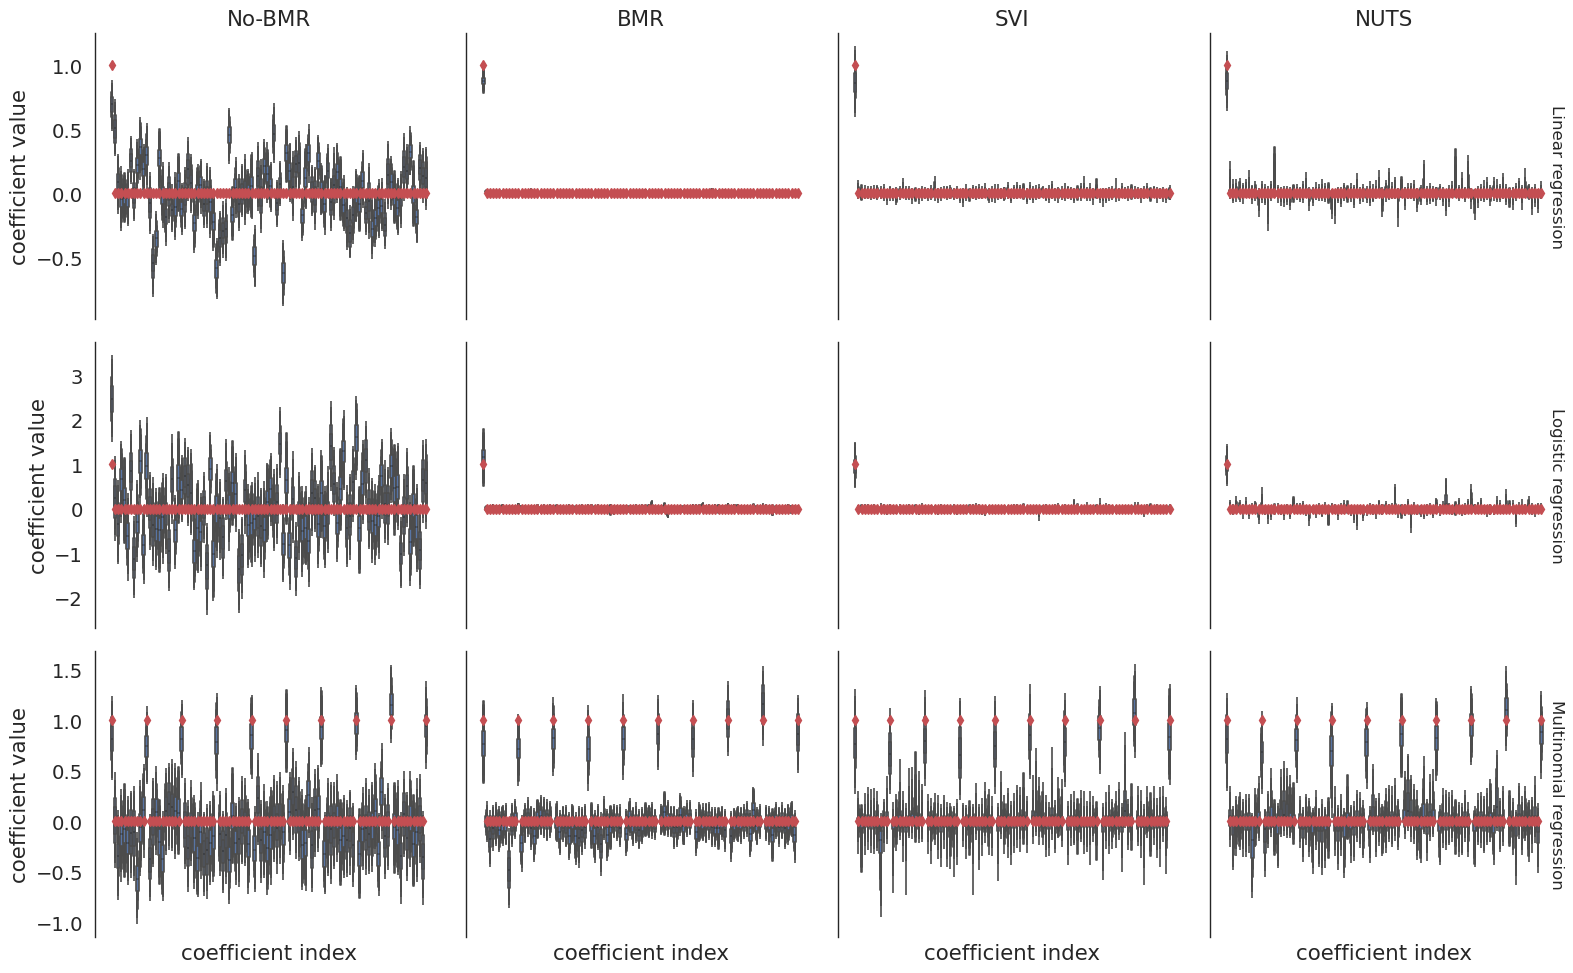

In [12]:
fig = plot_posteriors(posterior)
fig.savefig('Fig1.pdf', bbox_inches='tight', transparent=True,  dpi=300)

## Nonlinear regression
$$ f(X) = {W}_2 \cdot ReLU(\pmb{W}_1 \cdot X)$$
$$ y \sim p\left(y| f(\pmb{X}), \pmb{\Theta}\right)$$

$$ p(W_1, W_2| \mathcal{D} ) \approx \prod_{ij} q(w^1_{ij}) \prod_{km} q(w^2_{ij})$$ 

In [13]:
seed = 29826666258
rng_key = random.PRNGKey(seed)

_D = 10
D = 100
N = 2000

rng_key, _rng_key = random.split(rng_key)
X_norm = random.normal(_rng_key, shape=(N, D))

hidden_dim = 2 * _D
W1 = jnp.pad(nn.one_hot(jnp.arange(hidden_dim), num_classes=hidden_dim), ((0, D - hidden_dim), (0, 0)))
W2 = nn.one_hot(0, num_classes=hidden_dim)
rng_key, _rng_key = random.split(rng_key)
y_norm = nn.relu(X_norm @ W1) @ W2 + random.normal(_rng_key, shape=(N,))

X_bern = random.normal(_rng_key, shape=(N, D))
rng_key, _rng_key = random.split(rng_key)
y_bern = random.bernoulli(_rng_key, nn.sigmoid(nn.relu(X_bern @ W1) @ W2))

hidden_dim = D + 1
rng_key, _rng_key = random.split(rng_key)
X_cat = random.normal(_rng_key, shape=(N, _D))
W1 = nn.one_hot(jnp.arange(_D), num_classes=hidden_dim)
W2 = nn.one_hot(jnp.arange(10), num_classes=hidden_dim).T
rng_key, _rng_key = random.split(rng_key)
y_cat = random.categorical(_rng_key, nn.relu(X_cat @ W1) @ W2)

hidden_dim = 2 * _D
rng_key, _rng_key = random.split(rng_key)
nnet1 = eqx.nn.MLP(D, 1, hidden_dim, 1, use_bias=False, key=_rng_key)

hidden_dim = D + 1
rng_key, _rng_key = random.split(rng_key)
nnet2 = eqx.nn.MLP(_D, 10, hidden_dim, 1, use_bias=False, key=_rng_key)

In [14]:
nonlin_posterior = {
    'nobmr': {},
    'bmr': {},
    'svi': {},
    'mcmc': {}
}

## No-U-turn sampler

In [15]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_norm, nnet1)
smpl_norm = bayes_reg.fit(
    y_norm, 
    num_samples=250, 
    warmup_steps=1000, 
    num_chains=4,
    progress_bar=True
)

nonlin_posterior['mcmc']['norm'] = smpl_norm['beta']

sample: 100%|██████████| 1250/1250 [03:07<00:00,  6.65it/s]


In [16]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_bern, nnet1, regtype='logistic')
smpl_bern = bayes_reg.fit(
    y_bern, 
    num_samples=250, 
    warmup_steps=1000, 
    num_chains=4, 
    progress_bar=True
)
nonlin_posterior['mcmc']['bern'] = smpl_bern['beta']


sample: 100%|██████████| 1250/1250 [01:59<00:00, 10.47it/s]


In [17]:
rng_key, _rng_key = random.split(rng_key)
bayes_reg = BayesRegression(_rng_key, X_cat, nnet2, regtype='multinomial')
smpl_cat = bayes_reg.fit(
    y_cat, 
    num_samples=250, 
    warmup_steps=1000, 
    num_chains=4, 
    progress_bar=True
)
nonlin_posterior['mcmc']['cat'] = smpl_cat['beta']

sample: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s]


## Stochastic variational inference

In [18]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_norm, nnet1)
svi_smpl_norm = svi_reg.fit(
    y_norm, 
    num_steps=50_000, 
    autoguide='mean-field', 
    progress_bar=True
)
nonlin_posterior['svi']['norm'] = svi_smpl_norm['beta']

100%|██████████| 50000/50000 [02:51<00:00, 291.08it/s, init loss: 22955.4043, avg. loss [47501-50000]: 3465.9834]


In [19]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_bern, nnet1, regtype='logistic')

svi_smpl_bern = svi_reg.fit(
    y_bern, 
    num_steps=50_000, 
    autoguide='mean-field', 
    progress_bar=True
)
nonlin_posterior['svi']['bern'] = svi_smpl_bern['beta']

100%|██████████| 50000/50000 [02:42<00:00, 307.94it/s, init loss: 19997.2227, avg. loss [47501-50000]: 1957.5085]


In [20]:
rng_key, _rng_key = random.split(rng_key)
svi_reg = SVIRegression(_rng_key, X_cat, nnet2, regtype='multinomial')
svi_smpl_cat = svi_reg.fit(
    y_cat, 
    num_steps=50_000, 
    autoguide='mean-field',
    progress_bar=True
)

nonlin_posterior['svi']['cat'] = svi_smpl_cat['beta']

100%|██████████| 50000/50000 [02:59<00:00, 278.58it/s, init loss: 24245.4121, avg. loss [47501-50000]: 5081.4385]


## Bayesian model reduction

In [21]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_norm, nnet1, posterior='normal')

nobmr_smpl_norm = bmr_reg.fit(
    y_norm, 
    num_steps=20_000, 
    progress_bar=True
)

nonlin_posterior['nobmr']['norm'] = nobmr_smpl_norm['beta']

100%|██████████| 20000/20000 [00:34<00:00, 584.60it/s, init loss: 7483.3789, avg. loss [19001-20000]: 3026.2334]


In [22]:
results, bmr_smpl_norm = bmr_reg.bmr(
    'mean-field',
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['norm'] = bmr_smpl_norm['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [01:14<00:00, 404.99it/s, init loss: 13757.7686, avg. loss [28501-30000]: 424.9550]


<dF> + F:  3450.6738


In [23]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_bern, nnet1, regtype='logistic', posterior='normal')
nobmr_smpl_bern = bmr_reg.fit(y_bern, num_steps=20_000, progress_bar=True)
nonlin_posterior['nobmr']['bern'] = nobmr_smpl_bern['beta']

results, bmr_smpl_bern = bmr_reg.bmr(
    'mean-field',
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['bern'] = bmr_smpl_bern['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [01:14<00:00, 401.88it/s, init loss: 13332.2607, avg. loss [28501-30000]: 511.5355]


<dF> + F:  1954.9412


In [24]:
rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRRegression(_rng_key, X_cat, nnet2, regtype='multinomial', posterior='normal')
nobmr_smpl_cat = bmr_reg.fit(y_cat, num_steps=20_000, progress_bar=True)
nonlin_posterior['nobmr']['cat'] = nobmr_smpl_cat['beta']

results, bmr_smpl_cat = bmr_reg.bmr(
    'mean-field', 
    num_steps=30_000, 
    progress_bar=True
)

nonlin_posterior['bmr']['cat'] = bmr_smpl_cat['beta']
print('<dF> + F: ', results.losses[-1000:].mean() + bmr_reg.results.losses[-1000:].mean())

100%|██████████| 30000/30000 [01:14<00:00, 404.14it/s, init loss: 11984.8076, avg. loss [28501-30000]: -2156.1648]


<dF> + F:  4986.876


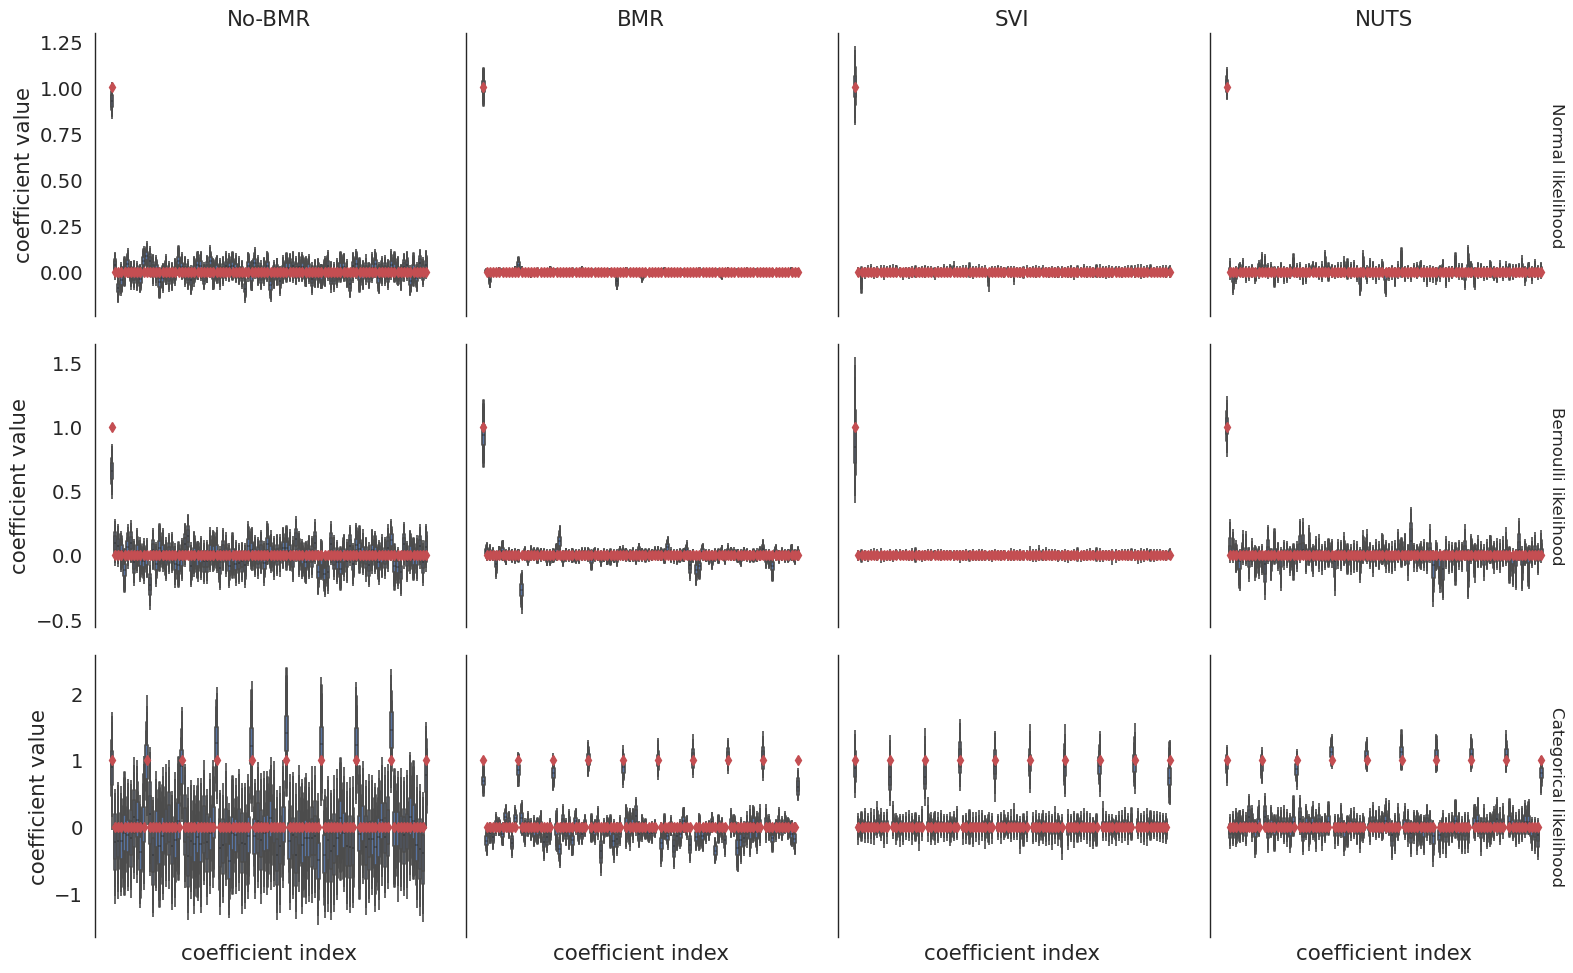

In [25]:
fig = plot_posteriors(nonlin_posterior, labels=['Normal likelihood', 'Bernoulli likelihood', 'Categorical likelihood'])
fig.savefig('Fig2.pdf', bbox_inches='tight', transparent=True,  dpi=300)

## Leave one out cross validation (LOO) for different data sizes 

In [5]:
seed = 987766545
rng_key = random.PRNGKey(seed)

_D = 10
D = 100
N = 4000

rng_key, _rng_key = random.split(rng_key)
X_norm = random.normal(_rng_key, shape=(N, D))

hidden_dim = 2 * _D
W1 = jnp.pad(nn.one_hot(jnp.arange(hidden_dim), num_classes=hidden_dim), ((0, D - hidden_dim), (0, 0)))
W2 = nn.one_hot(0, num_classes=hidden_dim)
rng_key, _rng_key = random.split(rng_key)
y_norm = nn.relu(X_norm @ W1) @ W2 + random.normal(_rng_key, shape=(N,))

X_bern = random.normal(_rng_key, shape=(N, D))
rng_key, _rng_key = random.split(rng_key)
y_bern = random.bernoulli(_rng_key, nn.sigmoid(nn.relu(X_bern @ W1) @ W2))

hidden_dim = D + 1
rng_key, _rng_key = random.split(rng_key)
X_cat = random.normal(_rng_key, shape=(N, _D))
W1 = nn.one_hot(jnp.arange(_D), num_classes=hidden_dim)
W2 = nn.one_hot(jnp.arange(10), num_classes=hidden_dim).T
rng_key, _rng_key = random.split(rng_key)
y_cat = random.categorical(_rng_key, nn.relu(X_cat @ W1) @ W2)

hidden_dim = 2 * _D
rng_key, _rng_key = random.split(rng_key)
nnet1 = eqx.nn.MLP(D, 1, hidden_dim, 1, use_bias=False, key=_rng_key)

hidden_dim = D + 1
rng_key, _rng_key = random.split(rng_key)
nnet2 = eqx.nn.MLP(_D, 10, hidden_dim, 1, use_bias=False, key=_rng_key)

In [6]:
import warnings
import arviz as az 
from numpyro.infer import log_likelihood

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


def get_loo(model, y, posterior):
    dims = {'obs': ['sample']}

    post_smpl = {}
    for key in posterior:
        if key != 'obs':
            post_smpl[key] = jnp.expand_dims(posterior[key], 0)


    log_lik = log_likelihood(
        model, post_smpl, parallel=True, batch_ndims=2, obs=y
    )

    idata = az.convert_to_inference_data(post_smpl)
    idata.add_groups(log_likelihood=log_lik, dims=dims)
    return az.loo(idata)

cutoffs = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
def iterate_over_data_for_loo(X, Y, Regression, nnet, rng_key, regtype='linear', *, opts={}, bmr=False):
    loo = []
    for n in cutoffs:
        x = X[:n]
        y = Y[:n]
        rng_key, _rng_key = random.split(rng_key)
        reg = Regression(_rng_key, x, nnet, regtype=regtype)
        smpl = reg.fit(y, **opts)

        if bmr:
            _, smpl = reg.bmr(
                'mean-field',
                num_steps=30_000,
                progress_bar=True
            )

        loo.append(get_loo(reg.model, y, smpl))
    return loo

rng_key = random.PRNGKey(57641)
loos = {
    'nobmr': {},
    'bmr': {},
    'svi': {},
    'mcmc': {}
}

In [7]:
loos = jnp.load('loos.npz', allow_pickle=True).get('loos').item()

In [8]:
opts = {
    'num_samples': 250,
    'warmup_steps': 1000,
    'num_chains': 4,
    'progress_bar': True
}

rng_key, _rng_key = random.split(rng_key)
loos['mcmc']['norm'] = iterate_over_data_for_loo(X_norm, y_norm, BayesRegression, nnet1, _rng_key, regtype='linear', opts=opts)
jnp.savez('loos.npz', loos=loos)

In [9]:
rng_key, _rng_key = random.split(rng_key)
loos['mcmc']['bern'] = iterate_over_data_for_loo(X_bern, y_bern, BayesRegression, nnet1, _rng_key, regtype='logistic', opts=opts)
jnp.savez('loos.npz', loos=loos)

sample: 100%|██████████| 1250/1250 [02:29<00:00,  8.35it/s]


In [10]:
rng_key, _rng_key = random.split(rng_key)
loos['mcmc']['cat'] = iterate_over_data_for_loo(X_cat, y_cat, BayesRegression, nnet2, _rng_key, regtype='multinomial', opts=opts)
jnp.savez('loos.npz', loos=loos)

sample: 100%|██████████| 1250/1250 [07:53<00:00,  2.64it/s]


In [11]:
opts = {
    'num_steps': 50_000, 
    'autoguide': 'mean-field',
    'progress_bar': True
}

rng_key, _rng_key = random.split(rng_key)
loos['svi']['norm'] = iterate_over_data_for_loo(X_norm, y_norm, SVIRegression, nnet1, _rng_key, regtype='linear', opts=opts)

100%|██████████| 50000/50000 [02:48<00:00, 296.60it/s, init loss: 25429.0273, avg. loss [47501-50000]: 6299.8140]


In [12]:
rng_key, _rng_key = random.split(rng_key)
loos['svi']['bern'] = iterate_over_data_for_loo(X_bern, y_bern, SVIRegression, nnet1, _rng_key, regtype='logistic', opts=opts)

100%|██████████| 50000/50000 [02:32<00:00, 327.94it/s, init loss: 21193.8730, avg. loss [47501-50000]: 3232.7002]


In [13]:
rng_key, _rng_key = random.split(rng_key)
loos['svi']['cat'] = iterate_over_data_for_loo(X_cat, y_cat, SVIRegression, nnet2, _rng_key, regtype='multinomial', opts=opts)

100%|██████████| 50000/50000 [02:53<00:00, 288.01it/s, init loss: 28474.0996, avg. loss [47501-50000]: 9316.0869]


In [14]:
jnp.savez('loos.npz', loos=loos)

In [15]:
opts = {
    'num_steps': 20_000, 
    'progress_bar': True
}

rng_key, _rng_key = random.split(rng_key)
loos['nobmr']['norm'] = iterate_over_data_for_loo(X_norm, y_norm, BMRRegression, nnet1, _rng_key, regtype='linear', opts=opts)

100%|██████████| 20000/20000 [00:31<00:00, 628.64it/s, init loss: 11018.1445, avg. loss [19001-20000]: 5896.9258]


In [16]:
rng_key, _rng_key = random.split(rng_key)
loos['nobmr']['bern'] = iterate_over_data_for_loo(X_bern, y_bern, BMRRegression, nnet1, _rng_key, regtype='logistic', opts=opts)

100%|██████████| 20000/20000 [00:26<00:00, 759.29it/s, init loss: 6625.0830, avg. loss [19001-20000]: 2752.3735]


In [17]:
rng_key, _rng_key = random.split(rng_key)
loos['nobmr']['cat'] = iterate_over_data_for_loo(X_cat, y_cat, BMRRegression, nnet2, _rng_key, regtype='multinomial', opts=opts)

100%|██████████| 20000/20000 [00:37<00:00, 536.17it/s, init loss: 13156.8223, avg. loss [19001-20000]: 11725.5137]


In [18]:
jnp.savez('loos.npz', loos=loos)

In [19]:
opts = {
    'num_steps': 20_000, 
    'progress_bar': True
}

rng_key, _rng_key = random.split(rng_key)
loos['bmr']['norm'] = iterate_over_data_for_loo(X_norm, y_norm, BMRRegression, nnet1, _rng_key, regtype='linear', opts=opts, bmr=True)

100%|██████████| 30000/30000 [01:17<00:00, 389.29it/s, init loss: 14201.7939, avg. loss [28501-30000]: 380.7584]


In [20]:
rng_key, _rng_key = random.split(rng_key)
loos['bmr']['bern'] = iterate_over_data_for_loo(X_bern, y_bern, BMRRegression, nnet1, _rng_key, regtype='logistic', opts=opts, bmr=True)

100%|██████████| 30000/30000 [01:18<00:00, 384.17it/s, init loss: 13561.7764, avg. loss [28501-30000]: 475.4785]


In [21]:
rng_key, _rng_key = random.split(rng_key)
loos['bmr']['cat'] = iterate_over_data_for_loo(X_cat, y_cat, BMRRegression, nnet2, _rng_key, regtype='multinomial', opts=opts, bmr=True)

100%|██████████| 30000/30000 [01:16<00:00, 391.83it/s, init loss: 12125.9121, avg. loss [28501-30000]: -2500.6821]


In [22]:
jnp.savez('loos.npz', loos=loos)

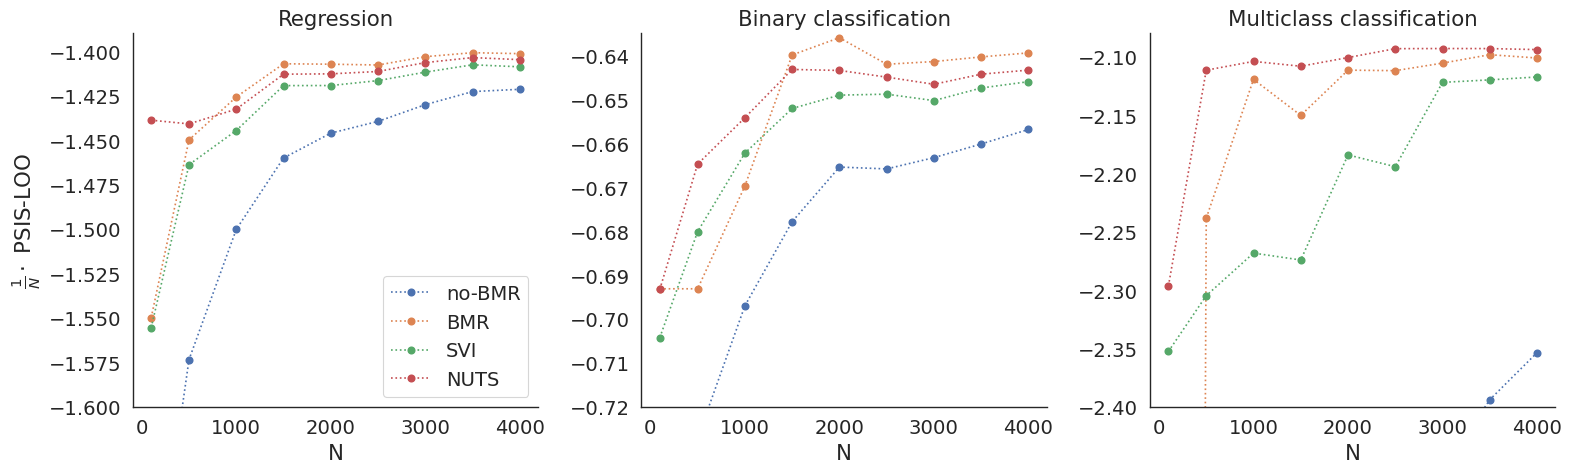

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
x = [500, 1000, 1500, 2000]

axes[0].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['nobmr']['norm'], cutoffs)], 'o:', label='no-BMR')
axes[0].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['bmr']['norm'], cutoffs)], 'o:', label='BMR')
axes[0].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['svi']['norm'], cutoffs)], 'o:', label='SVI')
axes[0].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['mcmc']['norm'], cutoffs)], 'o:', label='NUTS')

axes[1].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['nobmr']['bern'], cutoffs)], 'o:')
axes[1].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['bmr']['bern'], cutoffs)], 'o:')
axes[1].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['svi']['bern'], cutoffs)], 'o:')
axes[1].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['mcmc']['bern'], cutoffs)], 'o:')

axes[2].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['nobmr']['cat'], cutoffs)], 'o:')
axes[2].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['bmr']['cat'], cutoffs)], 'o:')
axes[2].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['svi']['cat'], cutoffs)], 'o:')
axes[2].plot(cutoffs, [l.elpd_loo/n for l, n in zip(loos['mcmc']['cat'], cutoffs)], 'o:')


axes[0].legend()
axes[0].set_ylabel(r'$\frac{1}{N} \cdot $ PSIS-LOO')
axes[0].set_xlabel('N')
axes[0].set_title('Regression')
axes[1].set_title('Binary classification')
axes[1].set_xlabel('N')
axes[2].set_title('Multiclass classification')
axes[2].set_xlabel('N')

axes[0].set_ylim([-1.6, -1.39])
axes[1].set_ylim([-0.72, -0.635])
axes[2].set_ylim([-2.4, -2.08])

fig.tight_layout()
sns.despine(fig)
fig.savefig('Fig3.pdf', bbox_inches='tight', transparent=True, dpi=300)